# **Parcial** **2** **Fisica** **Computacional** **I**
# **Ana** **Cristina** **Molina** cc 1044508251

# With this notebook we will:
## 1. Install packages needed for root
## 2. Download a binary root that compiled in google drive "colaboratory" environement
## 3. Modify the PATH in order to tell python where to look for pyROOT
## 4. Finally, a basic analysis example with pyROOT

##### Author: Jose Ruiz
##### Maintainer: Jose Ruiz
##### Developed at: Universidad de Antioquia


### 1. Install packages needed for root

In [73]:
!apt-get install git dpkg-dev cmake g++ gcc binutils libx11-dev libxpm-dev libxft-dev libxext-dev tar gfortran subversion

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libxext-dev is already the newest version (2:1.3.3-1).
libxft-dev is already the newest version (2.3.2-1).
libxpm-dev is already the newest version (1:3.5.12-1).
subversion is already the newest version (1.9.7-4ubuntu1).
binutils is already the newest version (2.30-21ubuntu1~18.04.2).
cmake is already the newest version (3.10.2-1ubuntu2.18.04.1).
dpkg-dev is already the newest version (1.19.0.5ubuntu2.3).
g++ is already the newest version (4:7.4.0-1ubuntu2.3).
gcc is already the newest version (4:7.4.0-1ubuntu2.3).
gfortran is already the newest version (4:7.4.0-1ubuntu2.3).
git is already the newest version (1:2.17.1-1ubuntu0.4).
libx11-dev is already the newest version (2:1.6.4-3ubuntu0.2).
tar is already the newest version (1.29b-2ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 33 not upgraded.


### 2. Mount the drive to get the root binary and untar it 

In [74]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [75]:
# After executing the cell above, Drive
# files will be present in "/content/drive/My Drive".
!ls "/content/drive/Shared drives/PyROOT_in_Google/"

BasicAnalysis.ipynb	  HistogrammingInROOT.ipynb
BasicPyROOTExample.ipynb  monje-a-lo-bonzo-blanco-y-negro.png
Chi2Fitting.ipynb	  piano-C5.wav
Data5.root		  Random2DHistos
DatosParcial2		  root_build_google_yikes.tar
DatosResonancia.root	  Temporal
FFT_imagen.ipynb	  TrimmedTree.root
FFT.ipynb		  TTreeExcercise.ipynb
FLUTEMI.WAV


In [0]:
!tar -xf /content/drive/Shared\ drives/PyROOT_in_Google/root_build_google_yikes.tar

In [77]:
!ls -ltrh

total 12K
drwxr-xr-x 44 root root 4.0K Sep 20  2018 root_build
drwxr-xr-x  1 root root 4.0K Nov  6 16:17 sample_data
drwx------  4 root root 4.0K Nov 18 02:45 drive



### 3. Modify the PATH in order to tell python where to look for pyROOT


In [0]:
import sys
sys.path.append("/content/root_build/")
sys.path.append("/content/root_build/bin/")
sys.path.append("/content/root_build/include/")
sys.path.append("/content/root_build/lib/")

### Importing necessary libraries

In [0]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp
from ROOT import TMath
import time as time

## **1) Datos suministrados e histograma**

### Reading tree in root file

In [80]:
DataChain=ROOT.TChain("SystemTree")
DataChain.Add("/content/drive/My Drive/FCI/Parcial2/N1044508251.root")

1

### Getting the number of events contained in the tree

In [81]:
NumberOfEventsToCheck=DataChain.GetEntries()
print("We are going to analyze ", NumberOfEventsToCheck, " events")

We are going to analyze  85000  events


In [82]:
NBINS = 200

Hist_x = ROOT.TH1F( 'Hist_x', 'Data distribution', NBINS, 0, 2000)
data = []
for entry in DataChain:
    fill = entry.x
    data.append(fill)
    Hist_x.Fill(fill)

Warning in <TROOT::Append>: Replacing existing TH1: Hist_x (Potential memory leak).


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


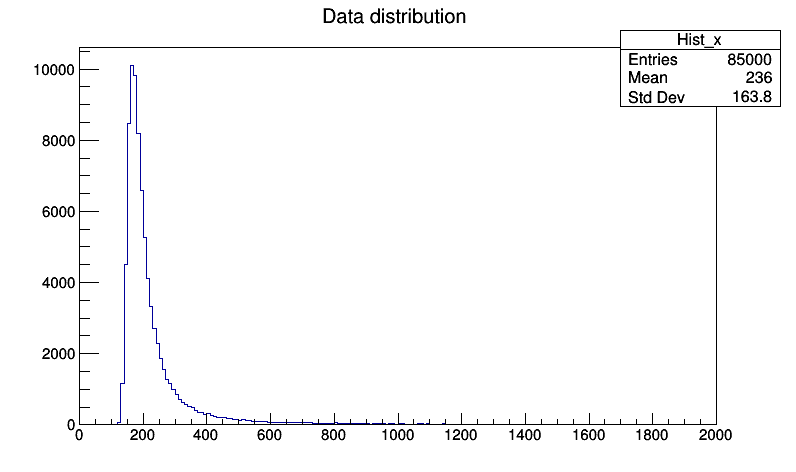

In [83]:
c1 = ROOT.TCanvas( 'c1', 'Data distribution', 200, 10, 800, 500 )
c1.SetFillColor( 0 )
Hist_x.Draw()
c1.Update()

ROOT.gROOT.GetListOfCanvases().Draw()

## NOTA: Se realizaron dos tipo de generacion de datos debido a que la plataforma de colab es muy variable a la hora de correr los códigos.

Con la función "metro" y "metro_var", se hicieron los calculos con metrópolis, sin embargo, estos llegaron a pasar de tomarse unos 3 min a quedarse corriendo en colab. Supongo que esto es debido a la disponibilidad de memoria que ofrece colab. Por tal razón, se hicieron cálculos con el generador aleatorio de Landau que está en ROOT.

(Los datos que se generaron en 3 minutos no los guarde :( por lo que cuando colab se puso lento no pude sacarlos, sin embargo, con más poder de computo es posible ejecutar las celdas de metropolis correctamente)

Se decidió dejar los calculos de metropolis en las celdas y no en terminal ya que la generación de probabilidades de Landau no se podia generar desde terminal, al menos no, usando la función de root que es la que se usa en este código.

La función de root para generar datos aleatorios de landau es una buena guía, para acercarse a los valores de mu y c.

Las gráficas que se subieron en el pull request se realizaron con el generador de datos aleatorios de ROOT.

## **2) Metropolis con Landau y nuevo histograma**

In [0]:
mu = 170
c = 14

#Landau de root
landau = ROOT.TF1("landau", "TMath::Landau(x,[0],[1])", min(data), max(data))
landau.SetParameters(mu, c)

In [0]:
inter =  np.array([min(data), max(data)])
theta = lambda : (inter[-1]-inter[0])*np.random.random_sample() + inter[0]

In [0]:
def metro(N):
    phi = [theta(), ]
    j=0
    while(j<N-1):
        #print(j)
        phi_0 = phi[-1]
        phi_p = theta()
        ds0 = -np.log(landau(phi_p)/landau(phi_0))
        if(ds0<0):
            phi.append(phi_p)
            j=j+1
        else:
            t = np.random.random_sample()
            if(t<(landau(phi_p)/landau(phi_0))):
                phi.append(phi_p)
                j=j+1
    return phi

In [0]:
start = time.perf_counter()

Y2 = metro(40000)

finish = time.perf_counter()

print(f'Finished in {round((finish-start)/60.,5)} minute(s)')

In [114]:
start = time.perf_counter()

Y3 = metro(45000)

print(f'Finished in {round((finish-start)/60.,5)} minute(s)')

Finished in 0.83605 minute(s)


In [0]:
Y = np.concatenate((Y2, Y3))

In [0]:
d = [landau.GetRandom() for i in range(85000)]

In [120]:
H_gen = ROOT.TH1F( 'H_gen', 'Metropolis', NBINS, 0, 2000)
H_roo = ROOT.TH1F( 'H_gen', 'Random Root', NBINS, 0, 2000)

for entry in Y:
    H_gen.Fill(entry)

for entry in d:
    H_roo.Fill(entry)

Warning in <TROOT::Append>: Replacing existing TH1: H_gen (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: H_gen (Potential memory leak).


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


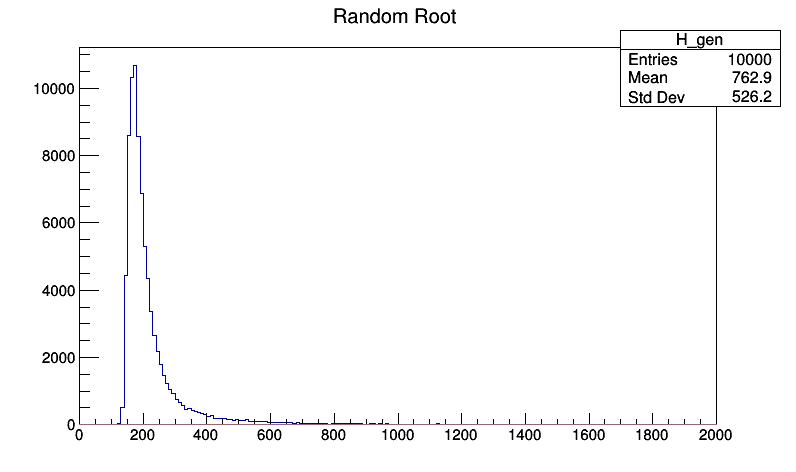

In [125]:
c2 = ROOT.TCanvas( 'c1', 'Metropolis', 100, 10, 800, 500 )
c2.SetFillColor( 0 )
H_roo.Draw()
H_gen.SetLineColor(49)
H_gen.Draw('same')
c2.Update()

ROOT.gROOT.GetListOfCanvases().Draw()

## **3) Chi-cuadrado y variación de (mu, c)**

In [0]:
def chi2(y, y_m):
  s = (y - y_m)**2
  r = np.sum(s/y)
  return r

In [0]:
def Gen_Root(mu, c):
  landau.SetParameters(mu, c)
  d = [landau.GetRandom() for i in range(85000)]

  Hist_d = ROOT.TH1F( 'Hist_d', 'Data distribution', NBINS, 0, 2000 )

  for entry in d:
    Hist_d.Fill(entry)

  Y_M = []  
  Y_D = []
  for k in range(NBINS):
    if(Hist_x.GetAt(k)!=0):
      Y_M.append(Hist_d.GetAt(k))
      Y_D.append(Hist_x.GetAt(k))
  
  Y_M = np.array(Y_M)
  Y_D = np.array(Y_D)
  
  chiS = chi2(Y_D, Y_M)

  return Hist_d, Y_M, chiS

In [0]:
pts = 25
C = np.linspace(11, 15, pts)
MU = np.linspace(167, 172, pts)

In [0]:
H = []
Y = []
pos = []
for i in C:
  for j in MU:
    A = Gen_Root(j, i)
    H.append(A[0])
    Y.append((A[1], A[2]))
    pos.append("P: ("+str(i)+", "+str(j)+")")

Warning in <TROOT::Append>: Replacing existing TH1: Hist_d (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Hist_d (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Hist_d (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Hist_d (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Hist_d (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Hist_d (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Hist_d (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Hist_d (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Hist_d (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Hist_d (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Hist_d (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Hist_d (Potential memory

In [0]:
Chi2 = [Y[i][1] for i in range(len(Y))]
I = Chi2.index(min(Chi2))
hist = H[I]
min(Chi2), pos[I]

(482.89227188344825, 'P: (14.833333333333332, 170.125)')

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


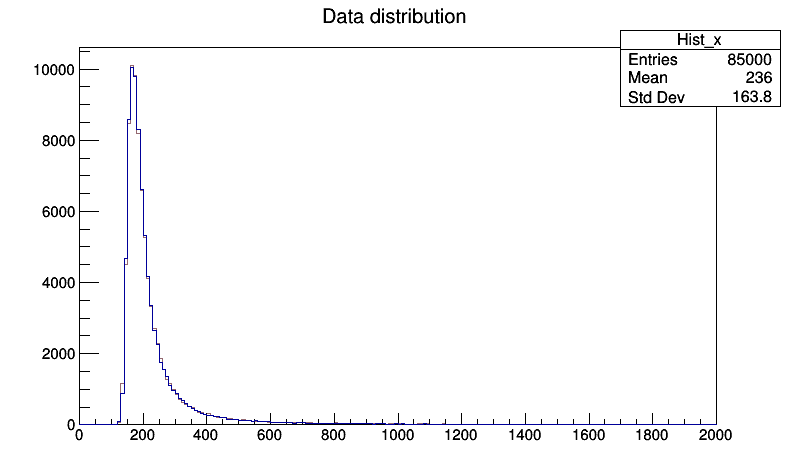

In [0]:
c3 = ROOT.TCanvas( 'c1', 'Metropolis', 100, 10, 800, 500 )
c3.SetFillColor( 0 )
Hist_x.SetLineColor(49)
Hist_x.Draw()
hist.Draw('same')
c3.Update()

ROOT.gROOT.GetListOfCanvases().Draw()

25 25 25


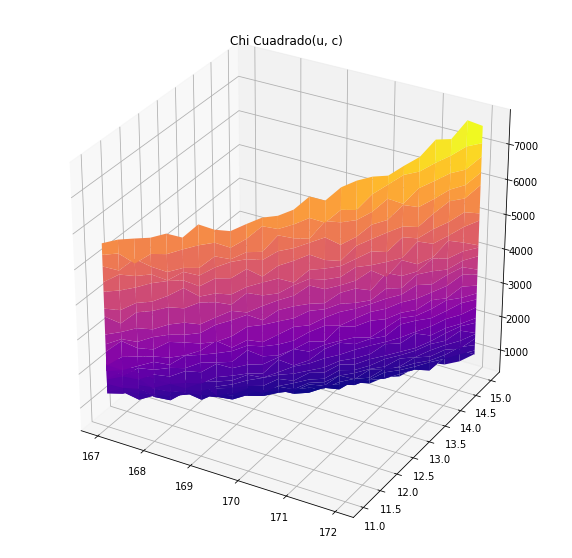

In [135]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

print(len(C), len(MU), len(Chi2))
Chi2 = np.array(Chi2).reshape((pts, pts))

fig = plt.figure(figsize = (10, 10))
ax = plt.axes(projection='3d')

ax.plot_surface(MU, C, Chi2, cmap='plasma', edgecolor='none')
ax.set_title('Chi Cuadrado(u, c)')
plt.show()

In [0]:
def metro_var(N, mu, c):
    landau.SetParameters(mu, c)
    phi = [theta(), ]
    j=0
    while(j<N-1):
        phi_0 = phi[-1]
        phi_p = theta()
        ds0 = -np.log(landau(phi_p)/landau(phi_0))
        if(ds0<0):
            phi.append(phi_p)
            j=j+1
        else:
            t = np.random.rand()
            if(t<(landau(phi_p)/landau(phi_0))):
                phi.append(phi_p)
                j=j+1
    return phi

In [0]:
def new_set(N1, N2, mu, c):
  Y1 = metro_var(N1, mu, c)
  Y2 = metro_var(N2, mu, c)
  return np.concatenate((Y1, Y2))

In [138]:
pts_M = 5
C_M = np.linspace(13.5, 15, pts_M)
MU_M = np.linspace(169.5, 171, pts_M)

H_M = []
Y_M = []
pos_M = []
for i in C_M:
  for j in MU_M:
    Y_MI = new_set(40000, 45000, j, i)
    h_MI = ROOT.TH1F( 'H_gen', 'Metropolis', NBINS, 0, 2000)

    for entry in Y_MI:
      h_MI.Fill(entry)

    H_M.append(h_MI)

    Y_mD = []
    Y_mM = []
    for k in range(NBINS):
      if(Hist_x.GetAt(k)!=0):
        Y_mD.append(Hist_x.GetAt(k))
        Y_mM.append(h_MI.GetAt(k))
   
    Y_mM = np.array(Y_mM)
    Y_mD = np.array(Y_mD)

    chiSm = chi2(Y_mD, Y_mM)

    Y_M.append((Y_mM, chiSm))

    pos_M.append("P: ("+str(i)+", "+str(j)+")")

Warning in <TROOT::Append>: Replacing existing TH1: H_gen (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: H_gen (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: H_gen (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: H_gen (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: H_gen (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: H_gen (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: H_gen (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: H_gen (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: H_gen (Potential memory leak).


In [139]:
Chi2_M = [Y_M[i][1] for i in range(len(Y_M))]
I_M = Chi2_M.index(min(Chi2_M))
hist_M = H_M[I_M]
min(Chi2_M), pos_M[I_M]

(84197.20507015583, 'P: (15.0, 170.0)')

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


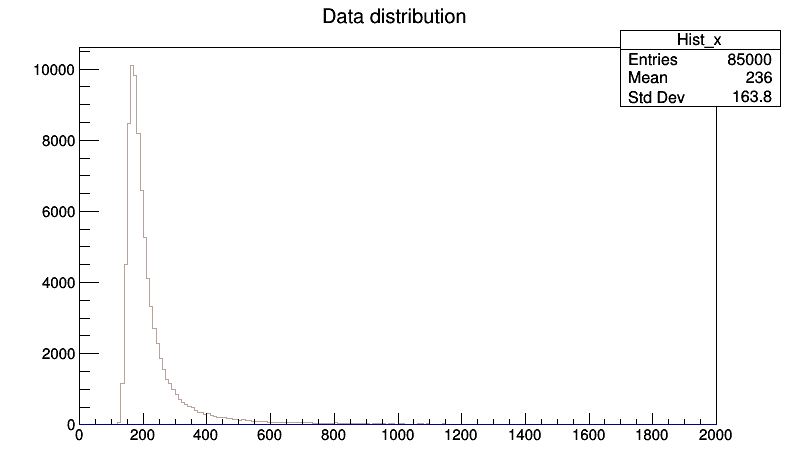

In [140]:
c4 = ROOT.TCanvas( 'c1', 'Metropolis', 100, 10, 800, 500 )
c4.SetFillColor( 0 )
Hist_x.SetLineColor(25)
Hist_x.Draw()
hist_M.Draw('same')
c4.Update()

ROOT.gROOT.GetListOfCanvases().Draw()

3 3 3


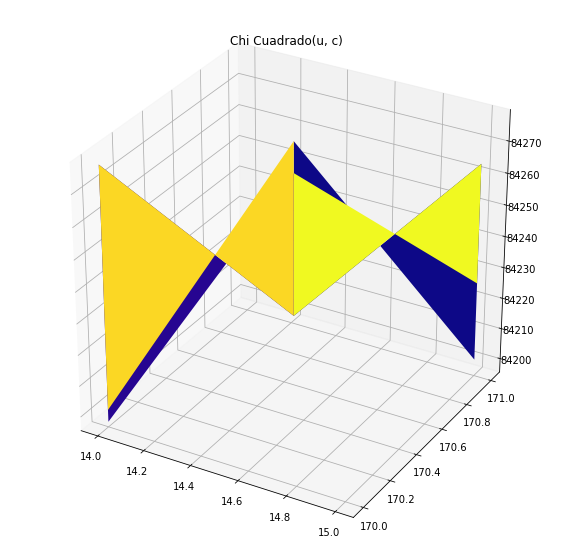

In [141]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

Chi2_M = np.array(Chi2_M).reshape((pts_M, pts_M))
print(len(C_M), len(MU_M), len(Chi2_M))

fig = plt.figure(figsize = (10, 10))
ax = plt.axes(projection='3d')

ax.plot_surface(C_M, MU_M, Chi2_M, cmap='plasma', edgecolor='none')
ax.set_title('Chi Cuadrado(u, c)')
plt.show()